In [1]:
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from numpy.polynomial.polynomial import polyfit, polyval

In [2]:
def get_cat(x, n = 200):
    xc = np.digitize(x, bins = np.linspace(x.min(), x.max(), n))
    return(xc)


In [3]:
w = np.load('../data/weigths.npy').astype('uint8')
alphaw = w.reshape(-1, w.shape[-1]).astype('float')/255
wl = [cv2.resize(w[:,:,i], (400, 300)) for i in range(w.shape[-1])]

# "Treat"       "Yield_Ref"   "NR_gwr"      "Treat_Yield" "Yield_Obs" 
treatnp = np.moveaxis(np.load('../data/treat.npy'), 2, 0)
treatnpf = treatnp.reshape(treatnp.shape[0], -1).astype('float')
treatnpr = [cv2.resize(i, (400, 300),  interpolation = cv2.INTER_NEAREST) for i in treatnp]
treat, yield_ref, NR_gwr, treat_yield, yield_obs = treatnpr


In [4]:
treat_pallete = np.uint8(255 * np.array(sns.color_palette("Blues", 201)))
treat_col = treat_pallete[get_cat(treat)]

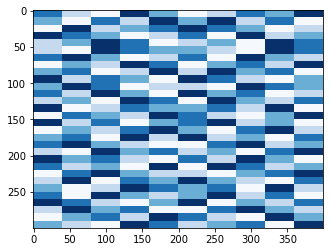

In [5]:
plt.imshow(treat_col)

In [6]:
yield_pallete = np.uint8(255 * np.array(sns.color_palette("YlOrRd", 251)))
yield_obs_col = yield_pallete[get_cat(yield_obs)]
yield_ref_col = yield_pallete[get_cat(yield_ref)]

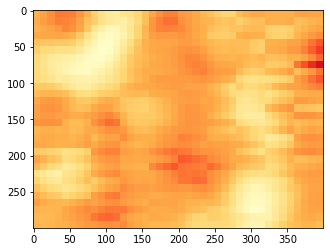

In [7]:
plt.imshow(yield_obs_col)

In [8]:
NRgwr_pallete = np.uint8(255 * np.array(sns.color_palette("viridis_r", 201)))
NRgwr_col = NRgwr_pallete[get_cat(NR_gwr)]

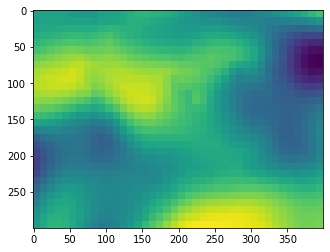

In [9]:
plt.imshow(NRgwr_col)

In [10]:
idx = np.arange(w.shape[-1]).reshape(w.shape[:-1])
idxnp = idx.repeat(10, 0).repeat(10, -1)
idx[1::2] = idx[1::2,::-1]
idx = idx.reshape(-1)

In [11]:
yield_imgl = []
treat_imgl = []

for i in tqdm(idx):
    im = 0.25 + 0.75 * (wl[i][:,:,None]/256)
    imf = im * yield_obs_col
    imf[idxnp == i] = [0,255,0]
    yield_imgl.append(imf.astype('uint8')[:,:,::-1])

    im = 0.1 + 0.9 * (wl[i][:,:,None]/256)
    imf = im * treat_col
    imf[idxnp == i] = [0,255,0]
    treat_imgl.append(imf.astype('uint8')[:,:,::-1])


yield_imgl.append(yield_obs_col[:,:,::-1])
treat_imgl.append(treat_col[:,:,::-1])

yield_np = np.stack(yield_imgl)
treat_np = np.stack(treat_imgl)


In [13]:
rgba_colors = np.zeros((alphaw.shape[0], 4))
rgba_colors[:, 0] = 1.0

my_dpi = 72
fig = plt.figure(figsize=(800/my_dpi, 600/my_dpi), dpi=my_dpi)

scat_l = []
i = 650
for i in tqdm(idx):
    fig.clf()

    rgba_colors[:, 3] = alphaw[i]
    plt.scatter(treatnpf[0], treatnpf[4], color=rgba_colors)
    intcp, slope = polyfit(treatnpf[0], treatnpf[4], 1, w = alphaw[i])
    plt.plot([0, 200], [intcp, intcp + 200*slope], linestyle='--', lw=2, color='black')
    fig.canvas.draw()
    X = np.array(fig.canvas.renderer.buffer_rgba())
    scat_l.append(X)


fig.clf()

rgba_colors[:, 3] = 1
plt.scatter(treatnpf[0], treatnpf[4], color=rgba_colors)
intcp, slope = polyfit(treatnpf[0], treatnpf[4], 1)
    
plt.plot([0, 200], [intcp, intcp + 200*slope], linestyle='--', lw=2, color='black')
fig.canvas.draw()
X = np.array(fig.canvas.renderer.buffer_rgba())
scat_l.append(X)
fig.clf()


<Figure size 800x600 with 0 Axes>

In [14]:
yield_treat = np.concatenate([yield_np, treat_np], 1)
scat_np = np.stack(scat_l)[:,:,:,:3]
frames = np.concatenate([yield_treat, scat_np], 2)

In [15]:
save_file = '../data/gwr_animation_examples.mkv'
fourcc = cv2.VideoWriter_fourcc(*'H264')
VIDEO_OUT = cv2.VideoWriter(save_file, fourcc, 30.0, (1200, 600))
[VIDEO_OUT.write(frame) for frame in frames]
VIDEO_OUT.release()